# Task 1

In [86]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np 
from scipy.io import loadmat
import pandas as pd
from mpl_toolkits.axes_grid1 import ImageGrid
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score,roc_auc_score, confusion_matrix
from sklearn.model_selection import RepeatedStratifiedKFold, GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from keras.preprocessing.image import ImageDataGenerator
import random
from sklearn.metrics import plot_confusion_matrix
import joblib 

### Helper Functions

In [232]:
def scree_plot(n_comp):
    n_comp = 30
    pca = PCA(n_components=n_comp)
    pc = pca.fit_transform(data)
    scree_df = pd.DataFrame({'exp_var':pca.explained_variance_ratio_,
                 'PC':[i for i in range(1,n_comp+1)]})
    colors = [n_comp * ['blue'] + (20-n_comp) * ['red'] ]
    scree_df['colors'] = colors[0]
    sns.barplot(x='PC',y="exp_var", 
               data=scree_df, color="c");
    plt.tight_layout()
    plt.xlabel('Principal Component')
    plt.ylabel('Explained Varaince')

def pcplot2d():
    n_comp = 20
    pca = PCA(n_components=n_comp)
    pc = pca.fit_transform(data)
    pc_df = pd.DataFrame(data= pc, columns = [('PC' + str(i)) for i in range(1,n_comp+1)])
    colors = []
    for i in labels:
        if i == 0:
            colors.append('neutral')
        else:
            colors.append('smile')
    pc_df['class'] =colors
    sns.lmplot( x="PC1", y="PC2",
      data=pc_df, 
      fit_reg=False, 
        hue='class', 
      legend=True,
      scatter_kws={"s": 80}) 
    
def pcplot3d():
    pca = PCA(n_components=3)
    pc = pca.fit_transform(data)
    pc_df = pd.DataFrame(data= pc, columns = ['PC1','PC2','PC3'])

    fig = plt.figure()
    ax = Axes3D(fig)
    ax.scatter(pc_df['PC1'], pc_df['PC2'], pc_df['PC3'], c=labels,depthshade=False)
    
def training_plot(model):
    results = pd.DataFrame(model.cv_results_)
    x = results['param_pca__n_components']
    y = results['mean_test_score']

    best_x = results[results['rank_test_score']==1]['param_pca__n_components']
    best_y = results[results['rank_test_score']==1]['mean_test_score']

    plt.figure(figsize=(6,4))
    sns.lineplot(x,y)
    plt.scatter(best_x,best_y,c='red',label='Highest Accuracy')
    plt.xlabel('Number of Principal Components')
    plt.ylabel('Mean Accuracy Score')
    # plt.title('Bayes Models: Number of Principal Components')
    plt.legend(loc=(.6,0.08))

def training_time_plot(model):
    results = pd.DataFrame(model.cv_results_)
    x = results['param_pca__n_components']
    y = results['mean_fit_time']

    best_x = results[results['rank_test_score']==1]['param_pca__n_components']
    best_y = results[results['rank_test_score']==1]['mean_fit_time']

    plt.figure(figsize=(6,4))
    sns.lineplot(x,y)
    plt.scatter(best_x,best_y,c='red',label='Highest Accuracy')
    plt.xlabel('Number of Principal Components')
    plt.ylabel('Mean Training Time')
    plt.legend()

def model_eval(model, X_test, y_test):
    ypred = model.predict(X_test)
    results = {'Accuracy' : [accuracy_score(y_test, ypred)],
               'F1': [f1_score(y_test, ypred)], 
               'Precision': [precision_score(y_test, ypred)],
                'Recall': [recall_score(y_test, ypred)], 
           'AUC': [roc_auc_score(y_test, ypred)]}
    results_df = pd.DataFrame(results)
    
#     results_df = results_df.style.hide_index()
    return results_df

def confusion_matrix(model, X_test, y_test, labels_list):
    ypred = model.predict(X_test)
    mat = confusion_matrix(y_test, ypred) 
    sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
                        xticklabels=labels_list,
                        yticklabels=labels_list)
    plt.xlabel('true label')
    plt.ylabel('predicted label');

In [3]:
#load data chunks and converts to numpy arrays
def load_data_chunks():
    raw_face = np.array(loadmat('./data/data.mat')['face'])
    raw_pose = np.array(loadmat('./data/pose.mat')['pose'])
    raw_illum = np.array(loadmat('./data/illumination.mat')['illum'])
    aug_neutral = np.load('data/aug_neutral.npy', allow_pickle=True)
    aug_smile = np.load('data/aug_smile.npy', allow_pickle=True)
    return raw_face, (raw_pose, raw_illum), (aug_neutral,aug_smile)

# creates face dataset and returns a tuple of 
def make_face_dataset(raw_face, augmented=False):
    neutral= raw_face[:,:,::3]
    smile = raw_face[:,:,1::3]
    variation = raw_face[:,:,2::3]
    
    if augmented == True:
        face_data = np.dstack((neutral, variation, smile))
        face_data = np.array(np.dsplit(face_data,face_data.shape[-1])).reshape((600,24,21))
        face_data = face_data/255
        face_data = face_data.reshape((600,24*21))
        face_labels = np.ravel(np.array([400 * [0] + 200 * [1]]))
        return face_data, face_labels
    else:
        face_data = np.dstack((neutral, smile))
        face_data = np.array(np.dsplit(face_data,face_data.shape[-1])).reshape((400,24,21))
        face_data = face_data/255
        face_data = face_data.reshape((400,24*21))
        face_labels = np.ravel(np.array([200 * [0] + 200 * [1]]))
        return face_data, face_labels

### load data and create dataset


In [131]:
#load data chunks
raw_face, raw_pose, aug_data = load_data_chunks()
#create face dataset
data, labels = make_face_dataset(raw_face, augmented=False)
#split data into train and test
X_train, X_test, y_train, y_test = train_test_split(data, labels, 
                                                    test_size=0.15, random_state=42, shuffle='true', stratify=labels)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(340, 504) (340,) (60, 504) (60,)


## Data Exploration

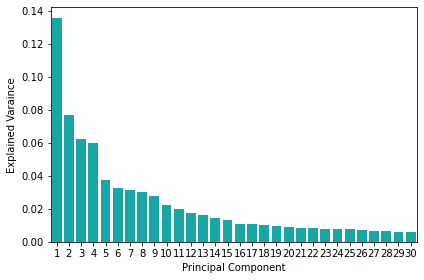

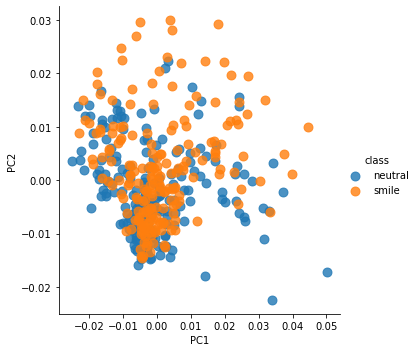

In [132]:
scree_plot(n_comp=16)
pcplot2d()

# Gaussian Bayes

In [274]:
def make_dataset(raw_face, num_illum, split=.15):
    neutral= list(raw_face[:,:,::3].reshape((24*21,200)).transpose())
    smile = list(raw_face[:,:,1::3].reshape((24*21,200)).transpose())
    illum = list(raw_face[:,:,2::3].reshape((24*21,200)).transpose())
    np.random.shuffle(neutral) 
    np.random.shuffle(smile)
    np.random.shuffle(illum)
    X_train, y_train, X_test, y_test = [],[],[],[]
    split_half = int((400*split)/2)
    
    for i in range(split_half):
        X_test.append(neutral.pop())
        y_test.append(0)
        X_test.append(smile.pop())
        y_test.append(1)
    for i in range(200-split_half):
        X_train.append(neutral.pop())
        y_train.append(0)
        X_train.append(smile.pop())
        y_train.append(1)
    for i in range(num_illum):
        X_train.append(illum.pop())
        y_train.append(0)
    
    train = list(zip(X_train, y_train))
    np.random.shuffle(train)
    train = np.array(train)
    X_train, y_train = train[:,0], train[:,1]
    X_train = np.array([X_train[i].reshape(504) for i in range(((200-split_half)*2) +num_illum)])
    
    test = list(zip(X_test, y_test))
    np.random.shuffle(test)
    test = np.array(test)
    X_test, y_test = test[:,0], test[:,1]
    X_test = np.array([X_test[i].reshape(504) for i in range(split_half*2)])
#     X_test, y_test = np.array(X_test), np.array(y_test)
    
    print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
    return X_train, y_train.astype(int), X_test, y_test.astype(int)

In [292]:
X_train, y_train, X_test, y_test = make_dataset(raw_face, num_illum=50, split=.15)

(390, 504) (390,) (60, 504) (60,)


In [293]:
X_train = X_train/255
X_test = X_test/255

In [294]:
#Gaussian Bayes pipeline components
scaler = StandardScaler()
pca = PCA()
gnb = GaussianNB()
#Parameter grid for grid search below
param_grid = {
    'pca__n_components': [i for i in range(1,40)]
}
pipe = Pipeline(steps=[('pca', pca), ('bayes', gnb)])
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=1)
bayes_search = GridSearchCV(pipe, param_grid, scoring='accuracy', n_jobs=-1, cv=5)
bayes_search.fit(X_train, y_train)
print("Best parameter (CV score=%0.3f):" % bayes_search.best_score_)
print(bayes_search.best_params_)
print(bayes_search.best_score_)

Best parameter (CV score=0.903):
{'pca__n_components': 15}
0.9025641025641026


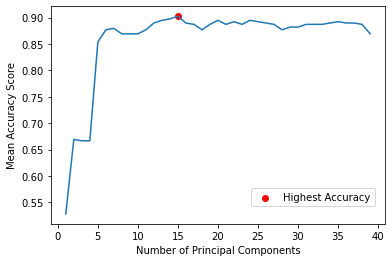

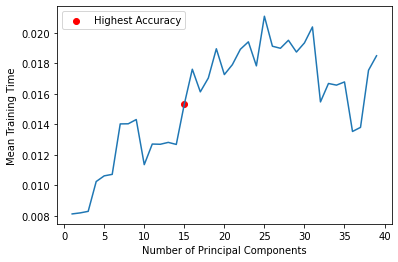

In [295]:
training_plot(bayes_search)
training_time_plot(bayes_search)

In [296]:
bayes_search_results = pd.DataFrame(bayes_search.cv_results_).sort_values(by='rank_test_score')[['rank_test_score',
                                                        'mean_test_score',
                                                        'std_test_score',
                                                        'param_pca__n_components']].head(5).set_index('rank_test_score')
bayes_search_results

,mean_test_score,std_test_score,param_pca__n_components
rank_test_score,,,
1,0.902564,0.010256,15
2,0.897436,0.011467,14
3,0.894872,0.024860,24
3,0.894872,0.020513,13
3,0.894872,0.031820,20


### Testing

In [297]:
top_pca = list(bayes_search_results['param_pca__n_components'])
accuracy, f1, precision, recall, auc = [], [], [], [], [] 
for i in range(5):
    pca = PCA(n_components=top_pca[i])
    model = Pipeline(steps=[('pca', pca), ('bayes', gnb)])
    model.fit(X_train, y_train)
    results = model_eval(model, X_test, y_test)
    accuracy.append(results['Accuracy'][0])
    f1.append(results['F1'][0])
    precision.append(results['Precision'][0])
    recall.append(results['Recall'][0])
    auc.append(results['AUC'][0])
    
testing_results = pd.DataFrame({'# of PC':top_pca, 'Accuracy':accuracy, 
                                'F1':f1,'Precision':precision, 'Recall':recall, 'AUC':auc})
testing_results = testing_results.sort_values(by="AUC", ascending =False)
testing_results

,# of PC,Accuracy,F1,Precision,Recall,AUC
0,15,0.883333,0.867925,1.000000,0.766667,0.883333
2,24,0.883333,0.867925,1.000000,0.766667,0.883333
3,13,0.883333,0.867925,1.000000,0.766667,0.883333
4,20,0.883333,0.867925,1.000000,0.766667,0.883333
1,14,0.866667,0.851852,0.958333,0.766667,0.866667


#### Best Model

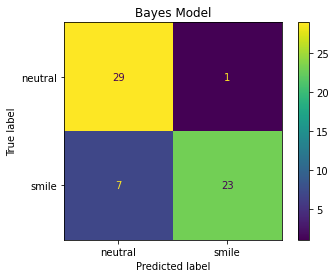

In [298]:
pca = PCA(n_components=15)
bayes_pipe = Pipeline(steps=[('pca', pcaB), ('bayes', gnb)])
bayes_pipe.fit(X_train, y_train)
plot_confusion_matrix(bayes_pipe, X_test, y_test, display_labels=['neutral','smile'])
plt.title('Bayes Model')
plt.show()

In [299]:
#save best bayes model
joblib.dump(knn_modelA, './models/smile_bayes.pkl')

['./models/smile_bayes.pkl']

# KNN

In [ ]:
scaler = StandardScaler()
pca = PCA()
knn = KNeighborsClassifier()
pipe = Pipeline(steps=[('scaler', scaler),('pca', pca), ('knn', knn)])
param_grid = {
    'pca__n_components': [i for i in range(1,31)],
    'knn__n_neighbors' : [i for i in range(1,11)],  
    'knn__metric' : ['euclidean','manhattan','chebyshev','minkowski','wminkowski','seuclidean','mahalanobis'],
    'knn__weights' : ['uniform','distance'],
    
}
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=1)
knn_search = GridSearchCV(pipe, param_grid, scoring='roc_auc', cv=5, n_jobs=-1)
knn_search.fit(X_train, y_train)
print("Best parameter (CV score=%0.3f):" % knn_search.best_score_)
print(knn_search.best_params_)

In [72]:
knn_search_results = pd.DataFrame(knn_search.cv_results_)
knn_search_results.sort_values(by='rank_test_score')[['rank_test_score',
                                                      'mean_test_score',
                                                      'param_pca__n_components',
                                                      'param_knn__n_neighbors']].head(5).set_index('rank_test_score')

,mean_test_score,param_pca__n_components,param_knn__n_neighbors
rank_test_score,,,
1,0.915398,5,9
2,0.914533,5,8
3,0.913754,25,10
4,0.913668,30,10
5,0.913235,23,10


#### testing

In [73]:
pca = PCA(n_components=5)
knn = KNeighborsClassifier(n_neighbors=9, metric='manhattan')
knn_modelA = Pipeline(steps=[('scaler', scaler),('pca', pca), ('knn', knn)])
knn_modelA.fit(X_train,y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=5)),
                ('knn',
                 KNeighborsClassifier(metric='manhattan', n_neighbors=9))])

In [74]:
model_eval(knn_modelA, X_test, y_test)

Accuracy,F1,Precision,Recall,AUC
0.866667,0.870968,0.843750,0.900000,0.866667


Text(0.5, 1.0, 'PCA: 22 and KNN:10')

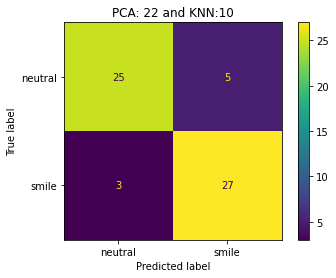

In [75]:
plot_confusion_matrix(knn_modelA, X_test, y_test, display_labels=['neutral','smile'])
plt.title('PCA: 22 and KNN:10')

In [76]:
pca = PCA(n_components=5)
knn = KNeighborsClassifier(n_neighbors=8, metric='manhattan')
knn_modelB = Pipeline(steps=[('scaler', scaler),('pca', pca), ('knn', knn)])
knn_modelB.fit(X_train,y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=5)),
                ('knn',
                 KNeighborsClassifier(metric='manhattan', n_neighbors=8))])

In [77]:
model_eval(knn_modelB, X_test, y_test)

Accuracy,F1,Precision,Recall,AUC
0.800000,0.793103,0.821429,0.766667,0.800000


Text(0.5, 1.0, 'PCA: 5 and KNN:9')

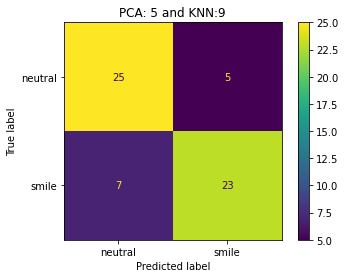

In [78]:
plot_confusion_matrix(knn_modelB, X_test, y_test, display_labels=['neutral','smile'])
plt.title('PCA: 5 and KNN:9')

In [79]:
pca = PCA(n_components=25)
knn = KNeighborsClassifier(n_neighbors=10, metric='manhattan')
knn_modelC = Pipeline(steps=[('scaler', scaler),('pca', pca), ('knn', knn)])
knn_modelC.fit(X_train,y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=25)),
                ('knn',
                 KNeighborsClassifier(metric='manhattan', n_neighbors=10))])

In [80]:
model_eval(knn_modelC, X_test, y_test)

Accuracy,F1,Precision,Recall,AUC
0.850000,0.836364,0.920000,0.766667,0.850000


Text(0.5, 1.0, 'PCA: 28 and KNN:10')

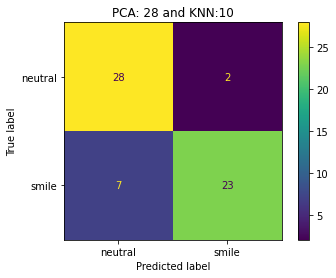

In [81]:
plot_confusion_matrix(knn_modelC, X_test, y_test, display_labels=['neutral','smile'])
plt.title('PCA: 28 and KNN:10')

In [89]:
#save best knn model
joblib.dump(knn_modelA, './models/smile_knn.pkl')

['./models/smile_knn.pkl']

In [ ]:
# knn_from_joblib = joblib.load('filename.pkl') 